__I - Instalation of libraries and listing directories of data.__

In [ ]:
pip install --upgrade pyabf

In [396]:
import pyabf
import pyabf.tools.memtest 
import matplotlib.pyplot as plt
import numpy as np
import os 
import os.path
from os import path
import csv
import pandas as pnd

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In the final version of this script the ideal scenario for file handling would be that a master list containing each individual experiment is read and the pipeline run individually for each .abf file inside folders corresponding to each cell. The quantifications would be saved in csv or dataframes containing columns for: name of cell and experiment, measurements, and important metadata such as type of experiment and date. 

In [397]:
# Functions and stuff I will implement to semi-automate the pipeline to account for alll cells/experiments in cd

#change directory to folder wih all abf files for 1 SINGLE CELL
os.chdir('/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/171219_SCH-028953/028953slice1cell1')
#os.chdir('/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/171219_SCH-028953/Test file') 
cwd = os.getcwd()

if path.exists('.DS_Store') == True: # my own computer creates this given that i use a backup drive, 
    os.remove('.DS_Store')           #you can comment this out but it shouldn't disrupt anything
        

#generate array of filenames in directory
contents = os.listdir('.')
print(contents)

['19d18005.abf_header.csv', '19d18002.abf_header.csv', '19d18003.abf_header.csv', '19d18004.abf_header.csv', '19d18006.abf_header.csv', '19d18009.abf_header.csv', '19d18009.abf', '19d18008.abf', '19d18001.abf_header.csv', '19d18000.abf_header.csv', '19d18008.abf_header.csv', '19d18007.abf_header.csv', '19d18002.abf_header.txt', '19d18003.abf', '19d18002.abf', '19d18005.abf_header.txt', '19d18000.abf', '19d18001.abf', '19d18005.abf', '19d18004.abf_header.txt', '19d18004.abf', '19d18006.abf', '19d18003.abf_header.txt', '19d18007.abf', '19d18009.abf_header.txt', '19d18001.abf_header.txt', '19d18006.abf_header.txt', '19d18007.abf_header.txt', '19d18000.abf_header.txt', '19d18008.abf_header.txt']


__II - Pre-processing and visualization__ <br>



First we generate txt files out of the header information in each ABF for easier access to variables. For now we keep these in case the .csv files down the line cause trouble.

In [398]:
def get_txt_metadata(contents):
    abf_files = len(contents)   
    all_header_files = []
    
    for i in range(abf_files):
        if '.txt' not in contents[i] and '.csv' not in contents[i]:
            header_txt = contents[i] + '_header.txt'
            header = open(header_txt,'w')
            all_header_files.append(header_txt)
            abf = pyabf.ABF(contents[i])
            header.write(abf.headerText)
            header.close()
    
        elif '.txt' in contents[i] and '.csv' not in contents[i]:
            all_header_files.append(contents[i]) 
    
    print('all current metadata: ',all_header_files)
    return(all_header_files)


In [399]:
all_header_files = get_txt_metadata(contents)

all current metadata:  ['19d18009.abf_header.txt', '19d18008.abf_header.txt', '19d18002.abf_header.txt', '19d18003.abf_header.txt', '19d18002.abf_header.txt', '19d18005.abf_header.txt', '19d18000.abf_header.txt', '19d18001.abf_header.txt', '19d18005.abf_header.txt', '19d18004.abf_header.txt', '19d18004.abf_header.txt', '19d18006.abf_header.txt', '19d18003.abf_header.txt', '19d18007.abf_header.txt', '19d18009.abf_header.txt', '19d18001.abf_header.txt', '19d18006.abf_header.txt', '19d18007.abf_header.txt', '19d18000.abf_header.txt', '19d18008.abf_header.txt']


Then we generate a table from different sections of the txt file to organize the values from the protocol used in the experiment and make them accessible to our code. We then have a pandas Dataframe with all of the metadata we will need to analyze our experiment. However, it exists as a set of strings in a single column, which isn't useful. Using the pandas 'str.split' function on each cell allows us to turn this one-column table into two columns, the one on the right showing our values of interest. 

In [400]:
def gen_csv_metadata(header_files):
    num_files = len(all_header_files)
    csv_files = []

    for i in range(num_files):
        if '.csv' not in all_header_files[i] and '.txt' in all_header_files[i]:
            header = open(all_header_files[i],'r')
            metadata_str = []
    
            for line in header:
                if '=' in line:
                    metadata_str.append(line)
            
            csv_filename = all_header_files[i].replace('.txt','.csv')
            metadata_csv = pnd.DataFrame(metadata_str)
        
            metadata_csv.columns = ['Data'] # pandas doesn't like column names to be 0 
            metadata_csv[['Data','Values']] = metadata_csv.Data.str.split(" = ",expand=True) # remove whitespaces too!!!
            metadata_csv.to_csv(csv_filename, sep=',',index=False)
            csv_files.append(csv_filename)
        
    print('csv metadata:',csv_files)
    return csv_files


In [402]:
csv_files = gen_csv_metadata(all_header_files)
csv_files.sort()

csv metadata: ['19d18009.abf_header.csv', '19d18008.abf_header.csv', '19d18002.abf_header.csv', '19d18003.abf_header.csv', '19d18002.abf_header.csv', '19d18005.abf_header.csv', '19d18000.abf_header.csv', '19d18001.abf_header.csv', '19d18005.abf_header.csv', '19d18004.abf_header.csv', '19d18004.abf_header.csv', '19d18006.abf_header.csv', '19d18003.abf_header.csv', '19d18007.abf_header.csv', '19d18009.abf_header.csv', '19d18001.abf_header.csv', '19d18006.abf_header.csv', '19d18007.abf_header.csv', '19d18000.abf_header.csv', '19d18008.abf_header.csv']


The format of our data folder includes a first file with a membrane test, where we can find the input resistance and series resistance for the cell in that experiment. These sweeps also contain a spectrum of different presynaptic stimulation currents.

In [403]:
# Plot all sweeps with 3D offset to see each trace in more detail

def plot_sweep_3D(abf,i1,i2):

    plt.figure(figsize=(15, 10))
    cm = plt.get_cmap("viridis") #Make colormap to distinguish sweeps
    colors = [cm(x/abf.sweepCount) for x in abf.sweepList]
    frame_axis = range(abf.sweepPointCount)

    for i in abf.sweepList:
    
        abf.setSweep(i)
        dataX = abf.sweepX[i1:i2] + .010 * i #offsets are toggled around manually until clear picture is visible
        #dataX = frame_axis[i1:i2] .010 * i
        dataY = abf.sweepY[i1:i2] + 100 * i
        plt.plot(dataX, dataY, alpha=.5, color=colors[i]) #applies colormap

    plt.gca().axis('off')  # hide axes to enhance floating effect
    plt.show()

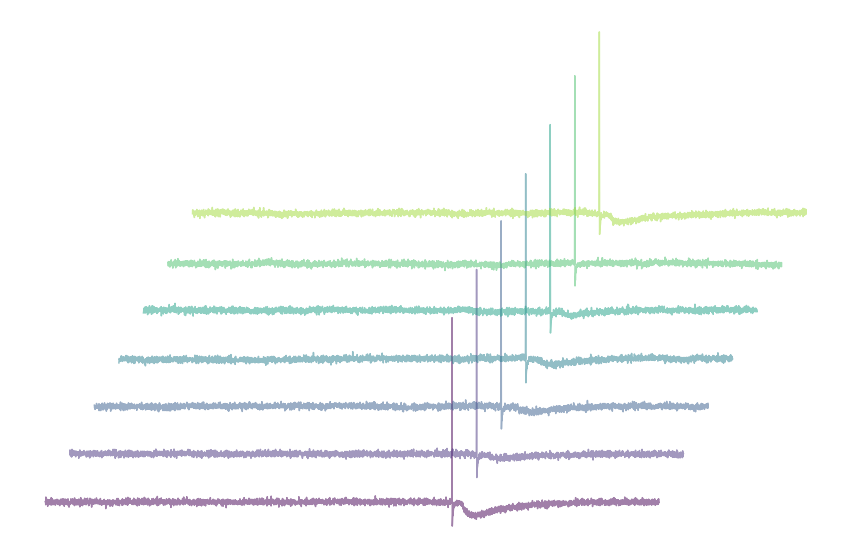

In [404]:
abf = pyabf.ABF("19d18001.abf") #specified
i1, i2 = 0, 5000 # start off with a decent range that does not include voltage step
abf_plot = plot_sweep_3D(abf,i1,i2)

__III - EPSC analysis__

We know that the main factors that contribute to input (membrane) resistance are: size of the cell, health of cell, channel composition of membrane, and other naturally occuring effects that can vary between cells and experiments. Another form of resistance that arises due to experimental design is series resistance, which partly depends on the physical properties of the cell but also on the dimensions of the pipette and capacitance of the ephys components. Both of these measures can serve as a way to monitor the quality of the prep overall and as the experiment progresses with different sweeps. <br>

We first start by restricting our window of analysis to only the first abf per folder, which contains a membrane test and tells us the state of the cell right before the experimental sweeps. This experiment has a command waveform that can be plotted along with its current output in the cell.

1. The large peaks at the start and end of the trace (capacitative current) serve to see the quality of the cell throughout the experiment.
2. The actual holding potential is actually around -63, due to corrections with the liquid junction potential that Andrea calculated for these experiments
3. The current near the very end of the voltage step corresponds to the input resistance. 

In [405]:
# Plot command waveform with abf.sweepC (only applies to current injection, not synaptic stimulation)

def plot_Rtest(sweep_ind,abf,i1,i2):
    
    abf.setSweep(sweep_ind)
    frame_axis = range(abf.sweepPointCount)
    fig = plt.figure(figsize=(8, 5))
    
    ax1 = fig.add_subplot(211)
    ax1.set_title("Resistance test")
    ax1.plot(frame_axis[i1:i2], abf.sweepY[i1:i2])

    real_mV = abf.sweepC - 70; # traces are saved as 0 = -70 mV

    # plot the DAC (voltage step)
    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.plot(frame_axis[i1:i2], real_mV[i1:i2], color='r')
    ax1.set_ylabel(abf.sweepLabelY)
    ax2.set_xlabel('data_frames')
    ax2.set_ylabel(abf.sweepLabelC)

    return fig

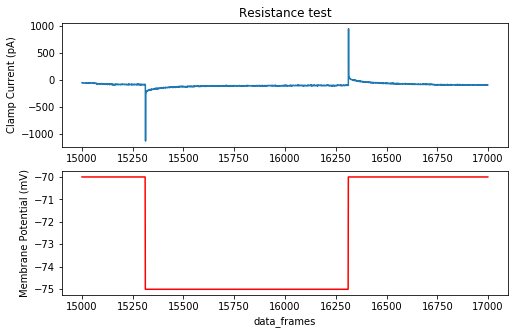

In [406]:
sweep_ind = 1
i1, i2 = 15000, 17000

Rtest_sample = plot_Rtest(sweep_ind,abf,i1,i2)

It seems like there are specific start and end points for the waveform that we could use to restrict our analysis window. These are saved in the metadata as sweepEpochs, which we can access from the csv using pandas.  

We will need to parse out some of these values as we attempt to implement them since that they are saved in the csv as strings. Some of the functions below will be used freely, while some are useful only for parsing out a specific parameter in the metadata.

In [407]:
def get_metadata_values(csv,parameter):

    # Obtains raw data string associated to specified parameter in metadata.
    csv_metadata = pnd.read_csv(csv)
    dic_metadata = csv_metadata.set_index('Data').to_dict()['Values'] # totally stolen from stack overflow and its FAST
    raw_str = dic_metadata[parameter] 
    return raw_str

def get_mV_step_interval(raw_str):
    # assumes only a single voltage step in voltage clamp experiments
    parsed_str = raw_str.split(', ')
    parsed_total = (len(parsed_str))
    for i in range(parsed_total):
        if '0.00' not in parsed_str[i]:
            # also stolen: this extracts string inside []
            values = parsed_str[i][parsed_str[i].find("[")+1:parsed_str[i].find("]")]
    step_points = (values.split(':'))
    step_start, step_end = int(step_points[0]), int(step_points[1])
    return step_start, step_end


We obtain the start and end values of the voltage step that we can use to obtain the currents at the onset of the step, where the capacitative current is seen, and the tailing end of the step, where we can more reliably estimate the input resistance.

In [409]:
# Turn the Rs and Ri formulas into a function for brevity using cell above

def get_resistances(step_start, step_end, abf):
    Rs = []
    Ri = []
    for i in abf.sweepList:
        abf.setSweep(i)
        neg_maxI = min(abf.sweepY[step_start:step_end])
        SeriesR = (abf.sweepC[step_start + 10]/neg_maxI) * 1000 #convert from gigaohms to megaohms
        Rs.append(SeriesR)
        Input_I = abf.sweepY[step_end - 10]
        InputR = ((abf.sweepC[step_end -10])/Input_I) * 1000
        Ri.append(InputR) 
    return Ri, Rs 

In [410]:
# Function for plotting results from above or just returning outputs
def plot_RiRs_persweep(csv_file,abf):    
    
    parameter = 'sweepEpochs' # This can be switched around if you want to use this function as a template for
                              # functions to call other parameters
    values = get_metadata_values(csv_file,parameter)    
    step_start, step_end = get_mV_step_interval(values)
    Ri, Rs = get_resistances(step_start, step_end, abf)

    fig = plt.figure(figsize=(8, 5))

    ax1 = fig.add_subplot(211)
    plt.scatter(abf.sweepList,Ri)
    ax1.set_ylabel('R(i) MOhm')

    ax2 = fig.add_subplot(212)
    plt.scatter(abf.sweepList,Rs)
    ax2.set_ylabel('R(series) MOhm')
    ax2.set_xlabel('Sweep number')
    return fig

def get_RiRs_persweep(csv_file,abf):
    parameter = 'sweepEpochs' # This can be switched around if you want to use this function as a template for
                              # functions to call other parameters
    values = get_metadata_values(csv_file,parameter)    
    step_start, step_end = get_mV_step_interval(values)
    Ri, Rs = get_resistances(step_start, step_end, abf)
    return Ri, Rs

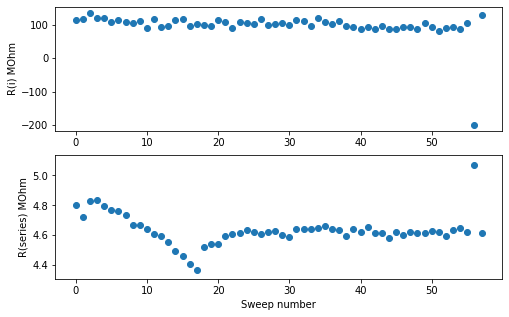

In [411]:

abf = pyabf.ABF("19d18000.abf")
fig = plot_RiRs_persweep(csv_files[2],abf)

These plots across all sweeps from the first abf file for each cell (termed the equilibration phase of the patch clamp) can be used to monitor the overall quality of that cell by obtaining the mean `Ri` and `Rs`. The rest of the files for one cell are sweeps with increasing presynaptic stimulation current. We start by plotting the Resistance profiles of these traces, since the timing is the same for the membrane test.

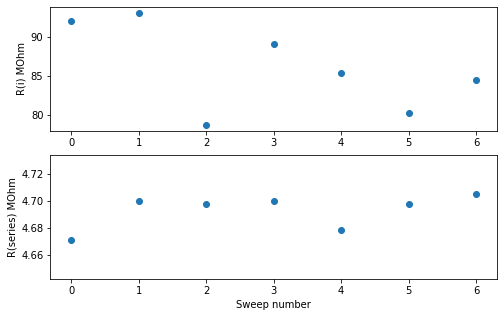

In [412]:
abf = pyabf.ABF("19d18006.abf")

fig = plot_RiRs_persweep(csv_files[9],abf)



For now we can write some code that iterates through each 'non-zero' file (non-equilibration or just purely experimental file) and extract these resistance measures into a Dataframe. If we get this working then doing the same for the kinetics of the EPSC could be done in a similar way (or at the same time). 

We take all of the `Ri` and `Rs` values of each segment (file), take their average, and compile them into a `DataFrame` that corresponds to this one cell. This can be done iteratively for each cell (each folder with abf files) to subsequenlty analyze any differences between genotypes. 

In [415]:
abf_files = []
for i in range(len(contents)):
    if '.txt' not in contents[i] and '.csv' not in contents[i]:
        abf_files.append(contents[i])
abf_files.sort()
abf_files.pop(0) # clear first file
#get stimulation currents from csv file
os.chdir('/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/171219_SCH-028953/')
segment_file = '171219_SCH-028953_slice1cell1.csv'
current_steps = pnd.read_csv(segment_file)
stim_int = current_steps['Stim Intensity (uA)'].tolist()
stim_int = stim_int[1:-1] # some cleanup 


#save values onto dataframes per cell
os.chdir('/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/171219_SCH-028953/028953slice1cell1')
mean_Ri = []
mean_Rs = []
for i in range(len(abf_files)):
    abf = pyabf.ABF(abf_files[i]) 
    Ri, Rs = get_RiRs_persweep(csv_files[i],abf)
    # Get average resistances per file and save onto dataframe
    mean_Ri.append(np.mean(Ri))
    mean_Rs.append(np.mean(Rs))
    
    # Get peak amplitude in other part of trace of interest
cell_df = pnd.DataFrame(list(zip(stim_int, mean_Ri,mean_Rs)), index=abf_files, columns =  
                      ["stimulus intensity uA", "Input Resistance MOhm", "Series Resistance MOhm"])

cell_df.sample(5)

# Save values of these sweeps in their own dataframe, where each column is a sweep (for later use, possibly)
# Do the same thing but with function that gets peak EPSC value, later on we'll design one for rise and decay times
# save time and date of experiment to check for batch effects by hour / day (e.g., save one column with hour start,
# another with date, etc)


,stimulus intensity uA,Input Resistance MOhm,Series Resistance MOhm
19d18003.abf,0.05,105.018977,4.764831
19d18008.abf,0.75,76.579595,4.624783
19d18005.abf,0.1,94.882996,4.712846
19d18001.abf,0.01,101.813304,4.617672
19d18009.abf,1,76.127860,4.578781


The following code or functions implement the same method but to obtain the peak amplitude of the EPSC. This part will be eventually integrated with the cell above as one function. We start by plotting a large time window at the start of the trace that contains the EPSC.

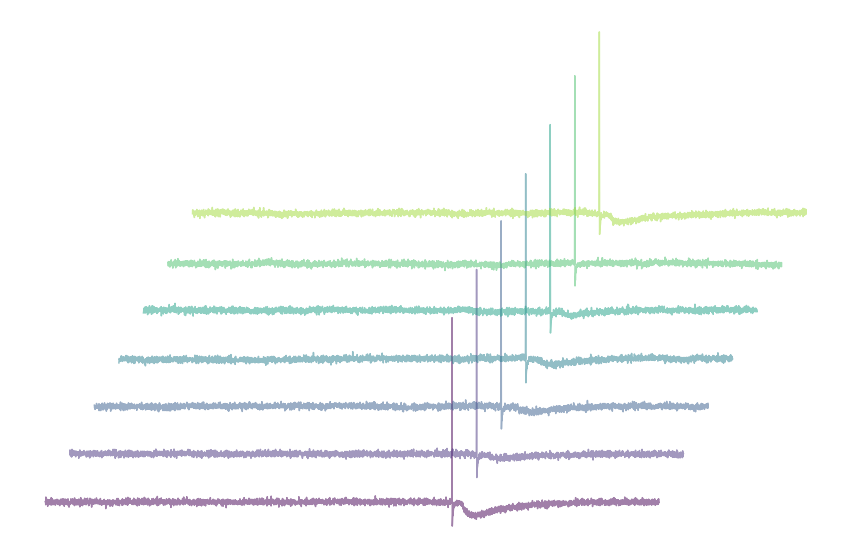

In [416]:
abf = pyabf.ABF("19d18001.abf") #specified
i1, i2 = 0, 5000 # start off with a decent range that does not include voltage step
abf_plot = plot_sweep_3D(abf,i1,i2)


Using `np.argmin` and `np.argmax` we can find the indices of the peaks in this broad window. We can use these values to then restrict our window even more so that, using `min`, we get the peak negative amplitude ONLY in the curve of the EPSC. Let us first compare the index for the most positive value in the trace (the huge artifact right at stimulus onset) and the following negative deflection.

In [417]:
pos_max_I = max(abf.sweepY[i1:i2]) # find highest amplitude, this artifact signals the start of are window of interest
pos_max_index = np.argmax(abf.sweepY[i1:i2]) # since margins start at 0, this is the real index for the max above
 
neg_maxI = min(abf.sweepY[i1:i2])
neg_max_index = np.argmin(abf.sweepY[i1:i2])

print(pos_max_index)
print(neg_max_index)


3314
3316


We can see that these are only 2 datapoints apart. However, the actual EPSC peak might be more negative that the negative deflection that precedes it, such that it would be safest to use `pos_max_index` as the starting point of the trace.

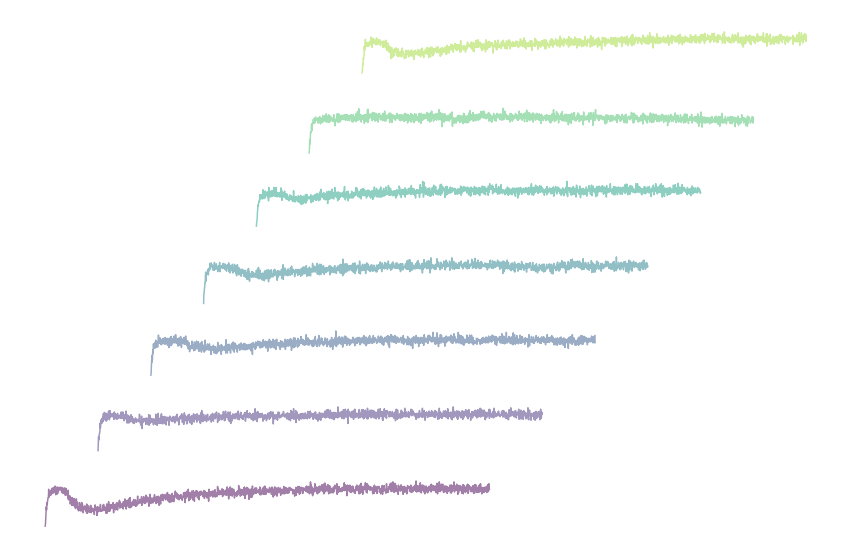

In [418]:
abf_plot = plot_sweep_3D(abf,neg_max_index,i2)

Adding a small number of frames to this index gets rid of the second peak. We plot one trace individually for now to be able to specify our indices on the plot with `plt.axes.Axes.axvline`.

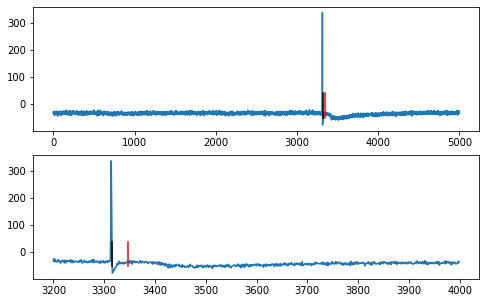

In [419]:
i3 = neg_max_index + 30
abf.setSweep(6)
frame_axis = range(abf.sweepPointCount)

fig = plt.figure(figsize=(8, 5))

ax1 = fig.add_subplot(211)
plt.plot(frame_axis[i1:i2],abf.sweepY[i1:i2])
plt.axvline(x=i3,color='r',ymin=0.1,ymax=0.3)
plt.axvline(x=neg_max_index,color='black',ymin=0.1,ymax=0.3)

ax2 = fig.add_subplot(212)
plt.plot(frame_axis[(i1+3200):(i2-1000)],abf.sweepY[(i1+3200):(i2-1000)])
plt.axvline(x=i3,color='r',ymin=0.1,ymax=0.3)
plt.axvline(x=neg_max_index,color='black',ymin=0.1,ymax=0.3)

This starting point looks fine, but we want to make sure that it works for other sweeps. We will adapt the `plot_sweep_3d` function to include vertical lines as above, but on another set of sweeps of another cell with a different jitter (the lag time between stimulus onset and EPSC onset). 

In [421]:
def plot_sweep_3D_with_vline(abf,i1,i2,neg_max_index):

    plt.figure(figsize=(10, 5))
    cm = plt.get_cmap("viridis") #Make colormap to distinguish sweeps
    colors = [cm(x/abf.sweepCount) for x in abf.sweepList]
    frame_axis = np.arange(abf.sweepPointCount)
    i3 = neg_max_index + 30
    
    for i in abf.sweepList:

        abf.setSweep(i)
        #dataX = abf.sweepX[i1:i2] + .010 * i #offsets are toggled around manually until clear picture is visible
        dataX = frame_axis[(i1+3200):(i2-1000)] + .010 * i
        dataY = abf.sweepY[(i1+3200):(i2-1000)] + 100 * i
        plt.plot(dataX, dataY, alpha=.5, color=colors[i]) #applies colormap
        plt.axvline(x=(i3 + 0.010 *i),color='r',ymin =0.1, ymax=0.3)
        plt.axvline(x=(neg_max_index+ 0.010 *i),color='black',ymin =0.1, ymax=0.3)        
        
    plt.gca().axis('off')  # hide axes to enhance floating effect
    plt.show()
    
    
    # find ~ 50 to 100 ms window after onset

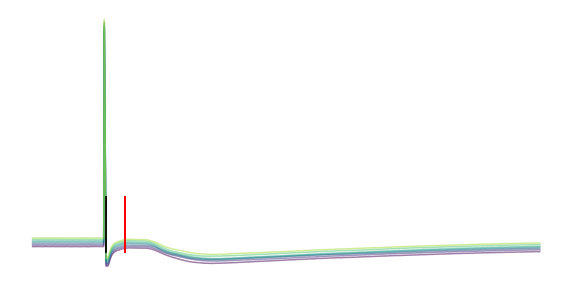

In [424]:
os.chdir('/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/171219_SCH-028953/028953slice1cell2')

abf = pyabf.ABF('19d18018.abf')


pos_max_index, neg_max_index = get_stim_onset_ind(abf,tickrate)
print(neg_max_index)
test_plot = plot_sweep_3D_with_vline(abf,i1,i2,neg_max_index)

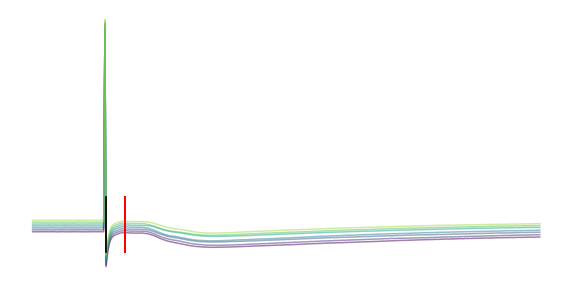

In [425]:
os.chdir('/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/171219_SCH-028953/028953slice1cell1')
abf = pyabf.ABF('19d18006.abf')



test_plot = plot_sweep_3D_with_vline(abf,i1,i2,neg_max_index)

From two different cells it looks like this method works, but the offset from which we choose are starting point for getting the peak current of the EPSC wave is just arbitrary. Instead of hard-coding this threshold (which is mainly so that we don't count the inward current artifact at the start as the EPSC peak), we can write a function that does the following:

1. Get the current and time-point (using tickrate as a conversion factor) of the inward inflection 
2. find the maximum point from there up to 5 ms after (this is as close as we can get to baseline and away from the artifact)
3. Use that value as your starting point and go 100 ms down and get the peak amplitude from there. 


Much like the resistances, we can save the average peak amplitudes from each file into the same `DataFrame`. We can then use this to plot the average trace from every stimulation step, but also plot the values that were picked as current minima. This way we can verify if the selection method is robust to noise or artifacts in the trace. 

In [323]:
os.chdir('/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/171219_SCH-028953/028953slice1cell1')
def get_peak_pA(abf,csv_files):
    
    parameter = 'dataRate' # tickrate
    peak_pA = []
    peak_pA_ind = []
    peak_pA_s = []
    pre_window_s = 0.005 # seconds to look at after artifact to find real starting point for EPSC, 100 ticks
    post_window_s = 0.01 # seconds to look after the real starting point to find EPSC peak, 200 ticks
    i1, i2 = 0, 5000 # first set of wide indices
    
    for i in abf.sweepList:
        
        tickrate = float(get_metadata_values(csv_files[i],parameter))
        abf.setSweep(i)
        
        pre_window_ticks = tickrate*pre_window_s 
        post_window_ticks = tickrate*post_window_s
    
        pos_max_ind = np.argmax(abf.sweepY[i1:i2]) # huge positive artifact

        #Fake calculations to show how numbers are managed with each sum operation
        pre_window_i1 = pos_max_ind + 2
        pre_window_i2 = int(pre_window_i1 + pre_window_ticks)
        # 3100 + 2 = 3102
        # 31200 + 100 = 3202
    
        post_window_i1 = int(pre_window_i1 + (np.argmax(abf.sweepY[pre_window_i1:pre_window_i2])))
        post_window_i2 = int(post_window_i1 + post_window_ticks)
        #3102 + 25 = 3127
        #3127 + 200 = 3327

        peak = min(abf.sweepY[post_window_i1:post_window_i2])
        peak_ind = int(post_window_i1 + (np.argmin(abf.sweepY[post_window_i1:post_window_i2])))
        peak_s = peak_ind/tickrate
        #3127 + 10 = 3137 (index of peak pA)
        
        peak_pA.append(peak)       
        peak_pA_ind.append(peak_ind) 
        peak_pA_s.append(peak_s) 
    
    return peak_pA, peak_pA_ind, peak_pA_s

In [330]:
abf = pyabf.ABF('19d18006.abf')
peak_pA, peak_pA_ind, peal_pA_ms = get_peak_pA(abf,csv_files)

print(peak_pA, peak_pA_ind, peal_pA_ms)

[-843.50586, -842.8955, -768.4326, -814.209, -687.25586, -725.09766, -713.501] [3486, 3492, 3480, 3482, 3490, 3482, 3479] [0.1743, 0.1746, 0.174, 0.1741, 0.1745, 0.1741, 0.17395]


By applying this function in the same pipeline we did for the cell resistances, we can include them in the dataframe and make more formal functions that compile all the measurements so far. 

In [393]:
def df_prep(contents):
    abf_files = []
    csv_files = []
    length = len(contents)
    for i in range(length):
        if '.txt' not in contents[i] and '.csv' not in contents[i]:
            abf_files.append(contents[i])
        elif '.csv' in contents[i]:
            csv_files.append(contents[i]) 
    abf_files.sort()
    csv_files.sort()
    abf_files.pop(0)
    csv_files.pop(0)
    return abf_files, csv_files

def get_stim_currents(data_path,segment_file):
    current_steps = pnd.read_csv(segment_file)
    stim_int = current_steps['Stim Intensity (uA)'].tolist()
    stim_int = stim_int[1:-1] # some cleanup 
    return stim_int

def data_summary_percell(abf_files,csv_files,stim_int):
    mean_Ri = []
    mean_Rs = []
    mean_peak_pA = []
    all_peak_times = pnd.DataFrame()
    for i in range(len(abf_files)):
        abf = pyabf.ABF(abf_files[i]) 
        Ri, Rs = get_RiRs_persweep(csv_files[i],abf)
        # Get average resistances per file and save onto dataframe
        mean_Ri.append(np.mean(Ri))
        mean_Rs.append(np.mean(Rs))
    
        # Get peak amplitude of EPSC
        peak_pA, peak_pA_ind, peak_pA_s = get_peak_pA(abf,csv_files)
        mean_peak_pA.append(np.mean(peak_pA))
    
        seg = abf_files[i].strip('.abf')
        segment = [seg for j in abf.sweepList]
        sweep_num = abf.sweepList
        peak_times = pnd.DataFrame(list(zip(peak_pA_ind,peak_pA_s,segment)), index=sweep_num, columns =  
                          ["peak pA frame", "peak pA time (s)",'segment'])
        all_peak_times = all_peak_times.append(peak_times,ignore_index=True)
    
    cell_df = pnd.DataFrame(list(zip(stim_int, mean_Ri, mean_Rs, mean_peak_pA)), index=abf_files, columns =  
                          ["stimulus intensity uA", "Input Resistance MOhm", "Series Resistance MOhm",
                           'Peak amplitude pA'])
    print(cell_df)
    print(all_peak_times)                       
    return cell_df
    return all_peak_times
    

In [395]:
abf_files, csv_files = df_prep(contents)

os.chdir('/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/171219_SCH-028953/') # replace with function call
data_path = os.getcwd()
segment_file = '171219_SCH-028953_slice1cell1.csv' # replace with function that outputs this
stim_int = get_stim_currents(data_path,segment_file)

os.chdir('/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/171219_SCH-028953/028953slice1cell1') # replace
summary = data_summary_percell(abf_files,csv_files,stim_int)

             stimulus intensity uA  Input Resistance MOhm  \
19d18001.abf                  0.01             101.813304   
19d18002.abf                 0.025             119.174865   
19d18003.abf                  0.05             105.018977   
19d18004.abf                 0.075             104.813549   
19d18005.abf                   0.1              94.882996   
19d18006.abf                  0.25              86.149890   
19d18007.abf                   0.5              77.907892   
19d18008.abf                  0.75              76.579595   
19d18009.abf                     1              76.127860   

              Series Resistance MOhm  Peak amplitude pA  
19d18001.abf                4.617672         -55.018833  
19d18002.abf                4.770380        -161.830353  
19d18003.abf                4.764831        -293.143127  
19d18004.abf                4.758909        -382.951996  
19d18005.abf                4.712846        -525.861450  
19d18006.abf                4.692666     

Now that we have a method to generate summaries for each cell (dataframes), we can proceed to the following:

1. Verify if selection method for EPSC peak is reliably by obtaining the mean trace of all sweeps of each current stimulation step, and plotting each timepoint in which the peak value was obtained. High variability in these points would suggest that another method should be used. 
2. Plot stimulus intensity versus peak amplitude for a cell as a way to describe the excitatory profile of this cell 
3. Obtain date-time values from metadata and compare to Series resistance/input resistance as a measure of prep quality
4. Compare data profiles between cells